In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 12.7 ms (started: 2025-05-10 17:34:35 +02:00)


In [2]:
!export SSL_CERT_FILE=/etc/ssl/certs/ca-certificates.crt

time: 1.08 s (started: 2025-05-10 17:34:35 +02:00)


In [3]:
import os
os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"

time: 15.8 ms (started: 2025-05-10 17:34:36 +02:00)


In [ ]:
import pandas as pd
import re  
from datasets import load_dataset

from openai import AsyncOpenAI

import getpass
from src.hallucination_classification.utils import *

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)
pd.set_option("max_colwidth", 100)

time: 3.55 s (started: 2025-05-10 22:39:25 +02:00)


In [241]:
'''
Dataset 1: potsawee/wiki_bio_gpt3_hallucination: accurate, minor_inaccurate, major_inaccurate
Dataset 2: fever
Dataset 3: original dataset
'''
DATASET =  3

time: 81.5 ms (started: 2025-05-15 11:42:46 +02:00)


## Load data

In [267]:
if DATASET == 1:
    df = pd.read_parquet("hf://datasets/potsawee/wiki_bio_gpt3_hallucination/data/evaluation-00000-of-00001-e91191b8ff41afbe.parquet")
    train_data = pd.DataFrame({
    'sentence': df['gpt3_sentences'].explode(),
    'annotation': df['annotation'].explode(),
    'original_text': df['wiki_bio_text'].repeat(df['gpt3_sentences'].str.len())
    }).reset_index(drop=True)
    # dataset.annotation = dataset.annotation.map({'major_inaccurate': 0, 'minor_inaccurate': 1, 'accurate': 2})
elif DATASET == 2:
    dataset = load_dataset("fever", "v1.0")
    zip_file_path = './wiki-pages/wiki-pages.zip'
    wiki_dict = load_wiki_dict_from_zip(zip_file_path)
    
    dataset_with_wiki = add_wikipedia_text(dataset['train'], wiki_dict)
    filtered_dataset = dataset_with_wiki.filter(filter_missing_wiki)
    train_data = pd.DataFrame(filtered_dataset)
elif DATASET == 3:
    data = read_json("./wiki-pages/entries_with_facts_and_retrieval.json")
    train_data = build_df(data)
train_data.head(5)

,fact,wiki,sentences,question,label
0,Petra van Stoveren won a silver medal.,"Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer fr...",[She also won a bronze at the 1986 world championships and a European silver in 1983 in the 4×10...,What did Petra van Staveren win a gold medal for?,INCORRECT
1,Petra van Stoveren won a medal in the 2008 Summer Olympics.,"Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer fr...","[Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer f...",What did Petra van Staveren win a gold medal for?,INCORRECT
2,"Petra van Stoveren won a medal in Beijing, China.","Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer fr...",[She also won a bronze at the 1986 world championships and a European silver in 1983 in the 4×10...,What did Petra van Staveren win a gold medal for?,INCORRECT
3,The 2008 Summer Olympics were held in Beijing.,"Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer fr...",[She also won a bronze at the 1986 world championships and a European silver in 1983 in the 4×10...,What did Petra van Staveren win a gold medal for?,INCORRECT
4,The 2008 Summer Olympics were held in China.,"Petronella (""Petra"") Grietje van Staveren (born 2 June 1966) is a former breaststroke swimmer fr...",[She also won a bronze at the 1986 world championships and a European silver in 1983 in the 4×10...,What did Petra van Staveren win a gold medal for?,INCORRECT


time: 108 ms (started: 2025-05-15 12:30:31 +02:00)


In [251]:
train_data.label.value_counts()

label
CORRECT      108
INCORRECT     98
Name: count, dtype: int64

time: 84.3 ms (started: 2025-05-15 11:59:42 +02:00)


# LLM classification

In [8]:
sasanka_token_proxi = getpass.getpass("Enter token for LLM proxi:")

time: 16.3 s (started: 2025-05-10 17:34:41 +02:00)


In [ ]:
async_client = AsyncOpenAI(api_key=sasanka_token_proxi, base_url="https://llm-proxy.seznam.net/v1")

time: 206 ms (started: 2025-05-15 13:04:57 +02:00)


In [ ]:
async def async_response(prompt):
    chat_completion = await async_client.chat.completions.create(
        model="llama3.1-sellma-70b-241114",
        temperature=0,
        messages=[{"role": "user", "content": prompt}]
        )
    
    return chat_completion.choices[0].message.content

In [ ]:
async def classify_hallucination(prompt):
    response = await async_response(prompt)
    match = re.findall(r'\b(SUPPORTS|REFUTES|NOT ENOUGH INFO)\b', response)
    classification = match[-1] if match else response
    
    return classification

time: 51.8 ms (started: 2025-05-10 23:47:10 +02:00)


## LLM as a judge 

In [ ]:
prompt_classify = lambda fact, wiki, question: f'''
You are a fact-checking assistant. You are given:

- A factual question.
- A generated answer from a language model.
- A relevant Wikipedia article.

Your task is:
1. Read the claim and the Wikipedia information carefully.  
2. Decide which single label fits best:
   - **SUPPORTS** - all essential aspects of the claim are directly verified by the information.  
   - **REFUTES** - the information clearly contradicts the claim.  
   - **NOT ENOUGH INFO** - the information is insufficient to determine support or refutation.
3. **Output only one word** — one of the three labels above.  
   Do **not** explain your reasoning, do **not** output anything else.

Return your result in JSON format with "label" and "reasons"
### User
Question:
{question}

Generated Answer:
{fact}

Wikipedia Information:
{wiki}
'''

time: 72.8 ms (started: 2025-05-15 13:06:29 +02:00)


In [282]:
sample = train_data.sample(100)
print(sample.label.value_counts())

if DATASET == 2: 
    value_to_set = sample.query('label == "SUPPORTS"')['wiki_info'].iloc[0]
    sample.loc[sample['label'] == "NOT ENOUGH INFO", 'wiki_info'] = value_to_set

label
CORRECT      53
INCORRECT    47
Name: count, dtype: int64
time: 82.6 ms (started: 2025-05-15 13:02:53 +02:00)


In [ ]:
for i, fow in sample.iterrows():
    claim = fow['fact']
    wiki = fow['wiki']
    label = fow['label']
    question = fow['question']
    
    prompt = prompt_classify(claim, wiki,question)
    classification = await async_response(prompt)
    
    print(f"Classification: {classification}, Label: {label}")
    sample.loc[i, 'proba'] = classification

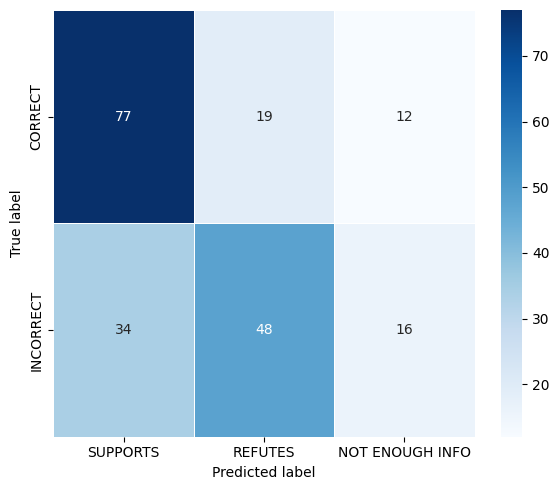

time: 261 ms (started: 2025-05-15 12:55:03 +02:00)


In [279]:
plot_confusion_matrix(train_data['label'], train_data['pred'])

## Evidence-First Decoding

In [89]:
prompt_useful_sentences = lambda wiki: f'''
From the article below, extract 1-3 sentences that are most likely to be useful for verifying factual claims.

[ARTICLE STARTS]
{wiki}
[ARTICLE ENDS]
'''
prompt_evaluate = lambda claim, sentences: f'''
Now evaluate the following claim using sentences:
Claim: {claim}
Evidence:
{sentences}
return only the answer in the format: "SUPPORTS / REFUTES / NOT ENOUGH INFO"
'''

time: 43.4 ms (started: 2025-05-10 21:58:16 +02:00)


In [ ]:
sentences = await async_response(prompt_useful_sentences(sample.query("id == 202110")['wiki_info']))
await classify_hallucination(prompt_evaluate(sample.query("id == 202110")['claim'], sentences)), sample.query("id == 202110")['label'][0]

('NOT ENOUGH INFO',
 48632    REFUTES
 Name: label, dtype: object)

time: 1.78 s (started: 2025-05-10 22:06:31 +02:00)


# Dense Retrieval + Re-ranking

## Dense Retrieval

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

dense_model = SentenceTransformer("distiluse-base-multilingual-cased-v1")

def dense_retrieve(claim, wiki_text, top_k=20):
    sentences = wiki_text.split('. ')
    claim_embedding = dense_model.encode(claim, convert_to_tensor=True)
    sentence_embeddings = dense_model.encode(sentences, convert_to_tensor=True)
    scores = util.cos_sim(claim_embedding, sentence_embeddings)[0]
    top_results = torch.topk(scores, k=top_k)
    return [sentences[i] for i in top_results[1]]


time: 2.74 s (started: 2025-05-11 15:41:26 +02:00)


## Cross-Encoder Re-ranker

In [207]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

cross_encoder = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

def rerank(claim, candidate_sentences, top_k=5):
    inputs = tokenizer([f"{claim} [SEP] {sent}" for sent in candidate_sentences],
                       return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        logits = cross_encoder(**inputs).logits
    scores = logits.squeeze()
    top_indices = torch.topk(scores, k=top_k).indices
    return [candidate_sentences[i] for i in top_indices]


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]


time: 7.02 s (started: 2025-05-11 15:41:10 +02:00)


In [ ]:
# archive prompts 

def prompt_judge(claim, wiki, pred): return f"""
### System
You are an impartial fact-checking judge.  
You receive:
• A natural-language **claim**.  
• A chunk of **Wikipedia information** that may contain supporting or contradicting evidence.  
• A **predicted label** chosen from SUPPORTS, REFUTES, NOT ENOUGH INFO .

Your task:

1. Read the claim and the Wikipedia information carefully.  
2. Determine the *correct* label:
   • **SUPPORTS** - all essential aspects of the claim are directly verified by the information.  
   • **REFUTES**  - the information clearly contradicts the claim.  
   • **NOT ENOUGH INFO** - the information is insufficient to decide either way.  
3. Compare the correct label to the *predicted* label.  
4. **Output only one word**:  
   • If the predicted label is correct, output that label unchanged.  
   • Otherwise, output the correct label you determined.  
Do **not** explain your reasoning, do **not** output anything else.

### User
Claim:
{claim}

Wikipedia_information:
{wiki}

Predicted_label:
{pred}

### Assistant
"""


def prompt_proba(fact, wiki, question): return f'''
You are a fact-checking assistant. You are given:

• A factual question.  
• A generated answer from a language model.  
• A relevant Wikipedia article.  

Your tasks:

1. Compare the generated answer with the Wikipedia information.   
2. Estimate **hallucination_probability** ∈ [0, 1]:  
   - Output a value near **0** when the answer is well supported.  
   - Output a value near **1** when it is clearly refuted.  
   - Output an intermediate value when evidence is unclear or partial.  
4. Return **exactly one float between 0 and 1**

Question:
{question}

Generated Answer:
{fact}

Wikipedia Information:
{wiki}

Probability of hallucination:
'''

In [223]:
for i, fow in sample.iterrows():
    claim = fow['claim']
    wiki = fow['wiki_info']
    label = fow['label']
    pred = fow['pred']
    
    prompt = prompt_judge(claim, wiki, pred)
    classification = await classify_hallucination(prompt)
    
    # print(f"Classification: {classification}, Label: {label}")
    sample.loc[i, 'pred_judge'] = classification

time: 1min 16s (started: 2025-05-14 16:31:25 +02:00)


0.9


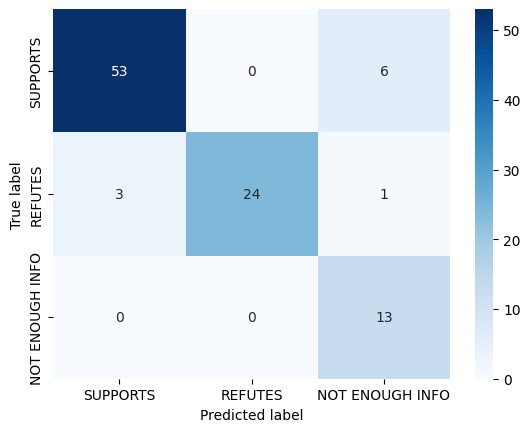

time: 233 ms (started: 2025-05-14 16:33:03 +02:00)


In [224]:
print((sample['pred_judge'] == sample['label']).mean())
plot_confusion_matrix(sample['label'], sample['pred_judge'], labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])